In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
data=pd.read_csv('Nifty_50.csv')



In [3]:
data.head(5)

Date    Price  Close_fin  Close_IT  Close_Energy  Close_FMCG  \
0  04/01/2012  4749.65    3369.94   6217.70       7037.05    10103.95   
1  05/01/2012  4749.95    3495.58   6356.15       7197.10    10215.70   
2  06/01/2012  4754.10    3513.79   6325.10       7165.75    10151.50   
3  07/01/2012  4746.90    3552.01   6301.55       7054.40    10130.80   
4  09/01/2012  4742.80    3558.00   6281.10       7114.60    10206.75   

   Close_Auto  
0     3356.10  
1     3414.05  
2     3386.10  
3     3426.75  
4     3416.00

In [4]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476 entries, 0 to 2475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2476 non-null   object 
 1   Price         2476 non-null   float64
 2   Close_fin     2476 non-null   float64
 3   Close_IT      2476 non-null   float64
 4   Close_Energy  2476 non-null   float64
 5   Close_FMCG    2476 non-null   float64
 6   Close_Auto    2476 non-null   float64
dtypes: float64(6), object(1)
memory usage: 135.5+ KB


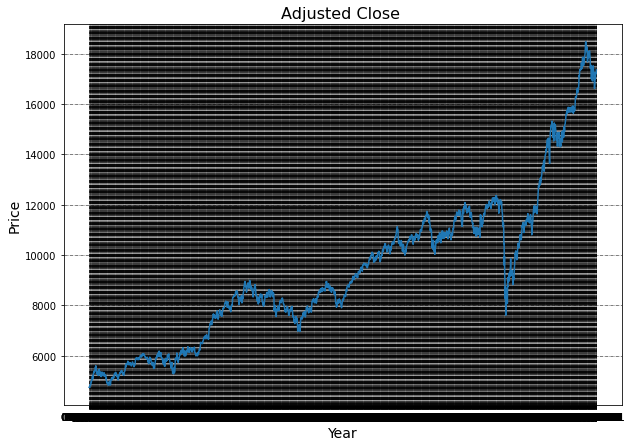

In [5]:
plt.figure(figsize=(10,7))
plt.plot(data['Date'],data['Price'])
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
# Define the label for the title of the figure
plt.title("Adjusted Close " , fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Show the plot
plt.show()

<AxesSubplot:>

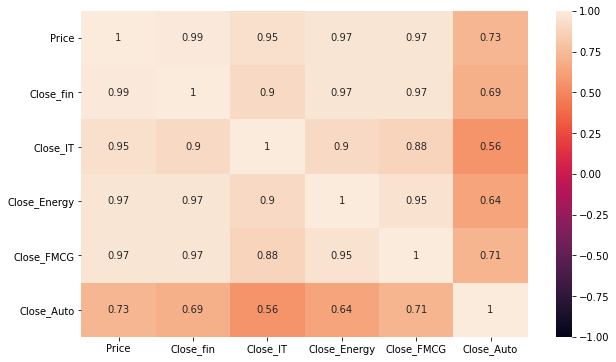

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(),vmin=-1, vmax=1,annot=True)

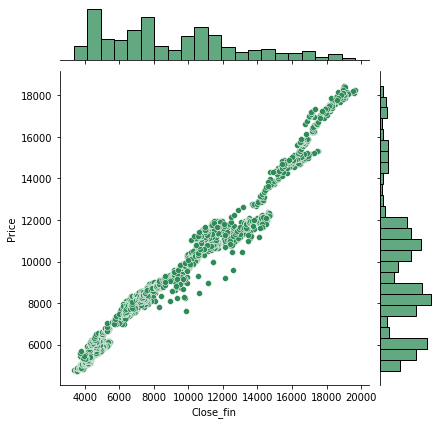

In [7]:
sns.jointplot(x='Close_fin', y='Price', data= data, kind='scatter', color='seagreen')

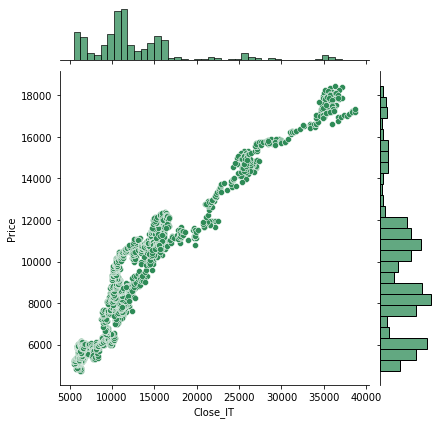

In [8]:
sns.jointplot(x='Close_IT', y='Price', data= data, kind='scatter', color='seagreen')

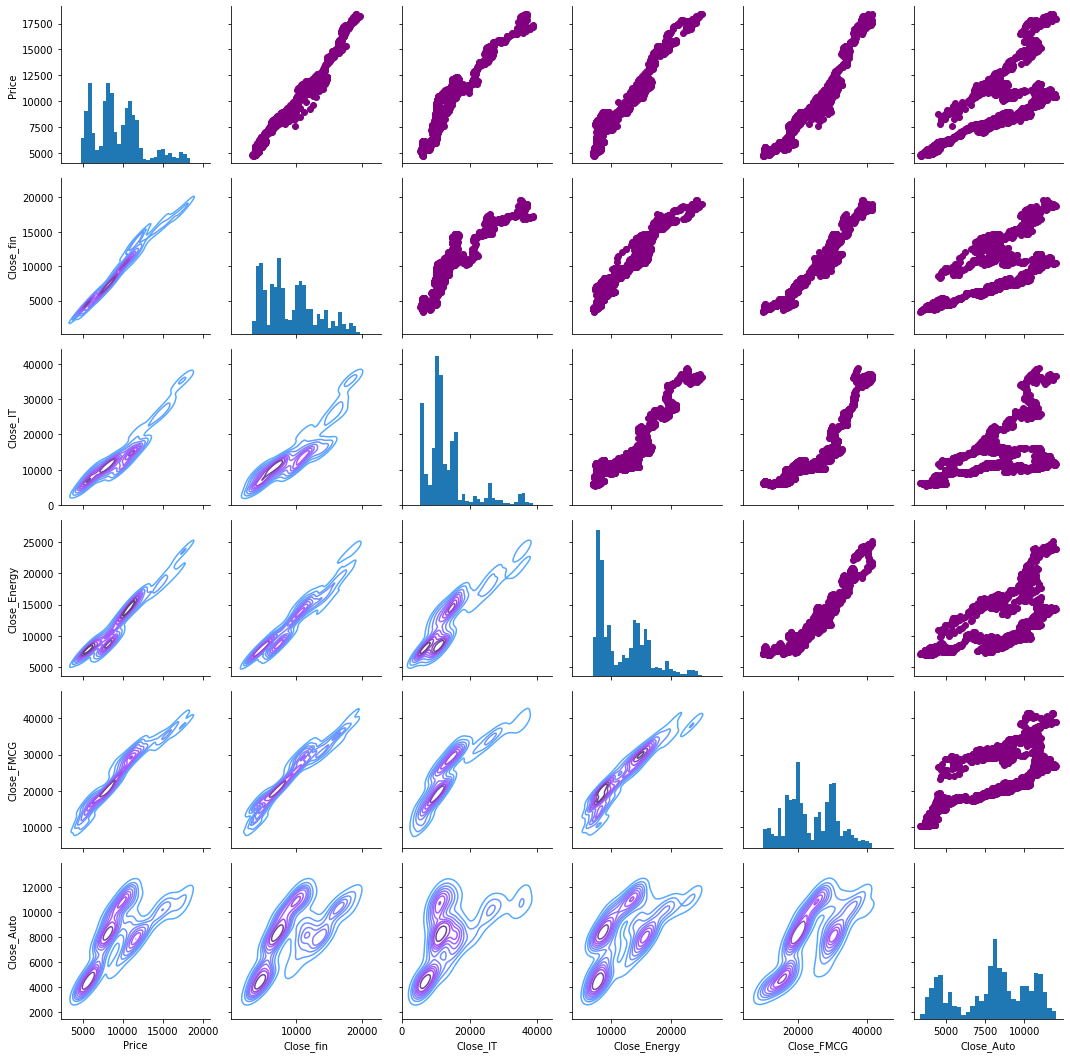

In [9]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(data.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

In [10]:
data['Date'] =  pd.to_datetime(data['Date'])

In [11]:
'Date','Price','Close_fin','Close_IT','Close_Energy','Close_FMCG','Close_Auto'

('Date',
 'Price',
 'Close_fin',
 'Close_IT',
 'Close_Energy',
 'Close_FMCG',
 'Close_Auto')

In [12]:
input_feature = data[['Close_fin','Close_IT','Close_Energy','Close_FMCG','Close_Auto','Price']]
input_data = input_feature.values

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
# input_data[:,:] = scaler.fit_transform(input_data[:,:])
input_data = scaler.fit_transform(input_data)



In [14]:
input_data.shape

(2476, 6)

In [15]:
df = pd.DataFrame(input_data)

In [16]:
df.iloc[120:,-1:]

5
120  -0.944955
121  -0.941883
122  -0.940827
123  -0.921932
124  -0.921976
...        ...
2471  0.797470
2472  0.818876
2473  0.816015
2474  0.814609
2475  0.836467

[2356 rows x 1 columns]

In [17]:
lookback = 60
total_size = len(data)

In [18]:
X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :-1]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 5])



In [19]:
X

[[array([-1.        , -0.95615368, -0.98235091, -1.        , -1.        ]),
  array([-0.98456621, -0.94781619, -0.96483317, -0.99290836, -0.98668688]),
  array([-0.98232927, -0.94968603, -0.96826448, -0.99698249, -0.99310796]),
  array([-0.97763427, -0.95110421, -0.98045193, -0.9982961 , -0.98376925]),
  array([-0.97689845, -0.95233572, -0.97386293, -0.99347633, -0.9862389 ]),
  array([-0.97847328, -0.95180879, -0.97460721, -0.99450755, -0.98731865]),
  array([-0.97813792, -0.95192622, -0.97822458, -0.99497081, -0.99086805]),
  array([-0.96575674, -0.94928556, -0.95757105, -0.98768562, -0.96842299]),
  array([-0.96575674, -0.95425072, -0.95190145, -0.99129331, -0.96603375]),
  array([-0.96188724, -0.97692663, -0.95630141, -0.98667026, -0.96008362]),
  array([-0.95540613, -0.97693567, -0.95433128, -0.98408427, -0.95965861]),
  array([-0.95684706, -0.96984775, -0.96826448, -0.98022274, -0.95366254]),
  array([-0.95684706, -0.96679458, -0.94599653, -0.97594238, -0.9340547 ]),
  array([-0.

In [20]:
y

[-0.9365018111655169,
 -0.9195077998434571,
 -0.916253162713654,
 -0.9103409359812149,
 -0.9155250559732058,
 -0.9284125452791381,
 -0.9270728288767134,
 -0.9295119864572147,
 -0.9222309190527331,
 -0.9323370406101535,
 -0.929606640333473,
 -0.9203596847297815,
 -0.9188597848444583,
 -0.9141416531663543,
 -0.9201922201794783,
 -0.9333345468445674,
 -0.9301235961191912,
 -0.933130676957242,
 -0.9350237544824072,
 -0.9347907603254637,
 -0.9264102517429056,
 -0.9277208438757123,
 -0.935111127291261,
 -0.9498989751897629,
 -0.9459235123869161,
 -0.9625534703387517,
 -0.9662158472432059,
 -0.9675410015108216,
 -0.97289986712052,
 -0.9759724775652111,
 -0.9708757303820741,
 -0.9831880153630523,
 -0.9814478402533813,
 -0.9783533866064766,
 -0.976227314924368,
 -0.9828603673298506,
 -0.986479057829878,
 -0.9739920272311922,
 -0.9741376485792819,
 -0.9646358556164335,
 -0.9639878406174345,
 -0.9697180406647615,
 -0.9735770063891367,
 -0.9856126108087446,
 -0.9846587909787576,
 -0.98245262755519

In [21]:
len(X), len(y)



(2416, 2416)

In [22]:
y

[-0.9365018111655169,
 -0.9195077998434571,
 -0.916253162713654,
 -0.9103409359812149,
 -0.9155250559732058,
 -0.9284125452791381,
 -0.9270728288767134,
 -0.9295119864572147,
 -0.9222309190527331,
 -0.9323370406101535,
 -0.929606640333473,
 -0.9203596847297815,
 -0.9188597848444583,
 -0.9141416531663543,
 -0.9201922201794783,
 -0.9333345468445674,
 -0.9301235961191912,
 -0.933130676957242,
 -0.9350237544824072,
 -0.9347907603254637,
 -0.9264102517429056,
 -0.9277208438757123,
 -0.935111127291261,
 -0.9498989751897629,
 -0.9459235123869161,
 -0.9625534703387517,
 -0.9662158472432059,
 -0.9675410015108216,
 -0.97289986712052,
 -0.9759724775652111,
 -0.9708757303820741,
 -0.9831880153630523,
 -0.9814478402533813,
 -0.9783533866064766,
 -0.976227314924368,
 -0.9828603673298506,
 -0.986479057829878,
 -0.9739920272311922,
 -0.9741376485792819,
 -0.9646358556164335,
 -0.9639878406174345,
 -0.9697180406647615,
 -0.9735770063891367,
 -0.9856126108087446,
 -0.9846587909787576,
 -0.98245262755519

In [23]:
X, y= np.array(X), np.array(y)
X.shape, y.shape



((2416, 60, 5), (2416,))

In [24]:
test_size = 120 

X_test = X[-test_size:]
Y_test = y[-test_size:]

X_rest = X[: -test_size]
y_rest = y[: -test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.15, random_state = 101)

In [25]:
Y_test

array([0.5941169 , 0.59452464, 0.61196279, 0.61802064, 0.62825054,
       0.62813404, 0.60323279, 0.58571455, 0.61366656, 0.61832645,
       0.61372481, 0.60236635, 0.59697108, 0.60702623, 0.60478366,
       0.62256403, 0.65832863, 0.67697544, 0.68218869, 0.67397564,
       0.67689535, 0.68007718, 0.68039027, 0.69235306, 0.71633689,
       0.72128074, 0.72878752, 0.72212534, 0.70489106, 0.71158236,
       0.73024373, 0.73170723, 0.73203488, 0.74198081, 0.7748694 ,
       0.80416113, 0.79601362, 0.81900723, 0.83203306, 0.83992573,
       0.83763948, 0.83638713, 0.83868067, 0.83664925, 0.8402461 ,
       0.860553  , 0.87657863, 0.87012032, 0.8427071 , 0.86674919,
       0.8645139 , 0.90474908, 0.90915412, 0.9094308 , 0.89392213,
       0.88849045, 0.87492582, 0.86238783, 0.88557074, 0.90465442,
       0.87898138, 0.90000182, 0.91527022, 0.9226605 , 0.92935908,
       0.95408559, 0.97983144, 1.        , 0.99151028, 0.96935399,
       0.9564665 , 0.94726323, 0.94879225, 0.96961611, 0.96125

In [26]:
y_train

array([-0.18052314, -0.5118918 ,  0.57757431, ..., -0.26808526,
       -0.14865391, -0.55305896])

In [27]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)



(1951, 60, 5)
(345, 60, 5)
(120, 60, 5)


In [28]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(rate = 0.2))


regressor.add(LSTM(units = 35, return_sequences = True))
regressor.add(Dropout(rate = 0.2))


regressor.add(LSTM(units = 25, return_sequences = True))
regressor.add(Dropout(rate = 0.2))


regressor.add(LSTM(units = 15, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))



In [29]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model123.h5', verbose=1, save_best_only=True, save_weights_only=True)
]



In [30]:
# regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
regressor.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)



Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 0.0177
Epoch 00001: val_loss improved from inf to 0.00233, saving model to model123.h5
244/244 [==============================] - 54s 165ms/step - loss: 0.0177 - val_loss: 0.0023 - lr: 0.0010
Epoch 2/100
244/244 [==============================] - ETA: 0s - loss: 0.0086
Epoch 00002: val_loss did not improve from 0.00233
244/244 [==============================] - 33s 136ms/step - loss: 0.0086 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/100
244/244 [==============================] - ETA: 0s - loss: 0.0083
Epoch 00003: val_loss did not improve from 0.00233
244/244 [==============================] - 35s 145ms/step - loss: 0.0083 - val_loss: 0.0043 - lr: 0.0010
Epoch 4/100
244/244 [==============================] - ETA: 0s - loss: 0.0077
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.00233
244/244 [==============================] - 31s 127ms/step 

In [32]:
regressor.load_weights('model1.h5')

In [33]:
results = regressor.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 125ms/step - loss: 0.0024
test loss, test acc: 0.002357788383960724


In [34]:
predicted_value = regressor.predict(X_test)



In [35]:
Y_test

array([0.5941169 , 0.59452464, 0.61196279, 0.61802064, 0.62825054,
       0.62813404, 0.60323279, 0.58571455, 0.61366656, 0.61832645,
       0.61372481, 0.60236635, 0.59697108, 0.60702623, 0.60478366,
       0.62256403, 0.65832863, 0.67697544, 0.68218869, 0.67397564,
       0.67689535, 0.68007718, 0.68039027, 0.69235306, 0.71633689,
       0.72128074, 0.72878752, 0.72212534, 0.70489106, 0.71158236,
       0.73024373, 0.73170723, 0.73203488, 0.74198081, 0.7748694 ,
       0.80416113, 0.79601362, 0.81900723, 0.83203306, 0.83992573,
       0.83763948, 0.83638713, 0.83868067, 0.83664925, 0.8402461 ,
       0.860553  , 0.87657863, 0.87012032, 0.8427071 , 0.86674919,
       0.8645139 , 0.90474908, 0.90915412, 0.9094308 , 0.89392213,
       0.88849045, 0.87492582, 0.86238783, 0.88557074, 0.90465442,
       0.87898138, 0.90000182, 0.91527022, 0.9226605 , 0.92935908,
       0.95408559, 0.97983144, 1.        , 0.99151028, 0.96935399,
       0.9564665 , 0.94726323, 0.94879225, 0.96961611, 0.96125

In [36]:
T = pd.DataFrame(Y_test,columns = ["True value"])

In [37]:
Z = pd.DataFrame(predicted_value,columns = ["predicted value"])

In [38]:
pd.concat([T, Z], axis=1)

True value  predicted value
0      0.594117         0.601004
1      0.594525         0.601111
2      0.611963         0.601071
3      0.618021         0.600890
4      0.628251         0.600706
..          ...              ...
115    0.797470         0.811423
116    0.818876         0.809212
117    0.816015         0.807410
118    0.814609         0.806286
119    0.836467         0.805962

[120 rows x 2 columns]

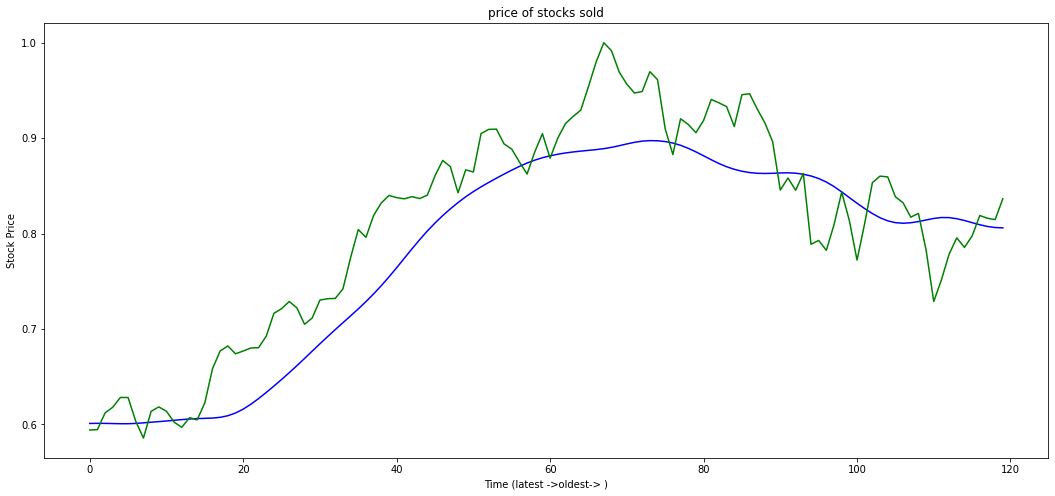

In [39]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'blue')
plt.plot(Y_test, color='green')
plt.title("price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Price")
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, predicted_value,squared=False)

0.048557059980028454

In [41]:
mean_squared_error(Y_test, predicted_value)

0.0023577880739040808

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [43]:
r2_score(Y_test, predicted_value)

0.8084823804729042

In [44]:
 mean_absolute_error(Y_test, predicted_value)

0.04063250886670174